In [93]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGeneratorNumba import getWeiner, getWeinerSubset, constructWeinerSubset
from tqdm.notebook import trange, tqdm
from numba import njit
from scipy.optimize import curve_fit
import pickle

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps

baseSteps = 1000000
Tend = 10
nRealizations = 100

"""
def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K
    
def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

    def simulatePython(self, ts, dws, dt):
       
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return self.zs

        def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return

        def simulateMilsteinPython(self,ts,dws,dt):
        self.dt = dt
        self.ts = ts
        zs = []
        for index, t in enumerate(self.ts):
            zs.append(self.z)
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * dws[index] + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (dws[index]**2 - dt)
            
            #Store results
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return zs
"""
def power(x,a,b):
        return a * np.power(x, b)

def linear(x,a,b):
        return np.multiply(x,float(a)) + float(b)

class Particle():
    def __init__(self, z, kBar = 1.0, h = 1.0):
        self.z = z*h
        self.kBar = kBar
        self.h = h

    
    def simulate(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs = self.simulateNumba(self.z, ts, dws, dt, self.kBar, self.h)

        return self.zs

    
    @staticmethod
    @njit
    def simulateNumba(z, ts, dws, dt, Kbar, h):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= h/2:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            

            #calc dKdz(z0)
            if z0 <= h/2:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz*dt + math.sqrt(2*K)*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            """if index == 0:
                print("Kbar: " + str(Kbar))
                print("h: ")
                print(h)
                print("K: " )
                print(K)
                print("dKdz: ")
                print(dKdz)
                print("dz: ")
                print(math.sqrt(2*K)*dws[index])"""

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
        return zs

    def simulateMilstein(self, ts, dws, dt,):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateMilsteinNumba(self.z, ts, dws, dt, self.kBar, self.h)

        return self.zs

    @staticmethod
    @njit
    def simulateMilsteinNumba(z, ts, dws, dt,  Kbar, h):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= h/2:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= h/2:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #calc dGdz
            if z0 < h/2 and z0 > 0:
                dGdz = math.sqrt(2) * (h - 4 * z0) / (2 * math.sqrt(z0 * (h - 2 * z0)))
            elif z0 > h/2 and z0 < h:
                dGdz = math.sqrt(2) * (3 * h - 4 * z0) / (2 * math.sqrt(-h**2 + 3 * h * z0 - 2 * z0**2))
            else:
                dGdz = 0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz * dt + math.sqrt(2 * K) * dws[index] + 0.5 * math.sqrt(2 * K) * dGdz * (dws[index]*dws[index] - dt) #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
                
        return zs

In [14]:
def getParticles(type, number, baseSteps, Tend, plot = False):
    assert(type == "Euler" or type == "Milstein")
    particles = []

    for i in tqdm(range(number)):
        ts, ws, dws, dt = getWeiner(baseSteps,Tend, 0, noIO=True)

        if type == "Euler":
            eulerParticle = Particle(0.25)
            zs = eulerParticle.simulate(ts, dws, dt)
            particles.append(eulerParticle) 

        if type == "Milstein":
            milsteinParticle = Particle(0.25)
            zs = milsteinParticle.simulateMilstein(ts, dws, dt)
            particles.append(milsteinParticle)

    if plot:
        for particle in particles:
            plt.plot(particle.ts, particle.zs)
    
    return particles

def getBothTypeParticles(number, baseSteps, Tend, plot = False):
    eulerParticles = getParticles("Euler", number, baseSteps, Tend, plot = False)
    mislteinParticles = getParticles("Milstein", number, baseSteps, Tend, plot = False)
    if plot:
        for eulerParticle, milsteinParticle in zip(eulerParticles, mislteinParticles):
            plt.plot(eulerParticle.ts, eulerParticle.zs, color = 'red')
            plt.plot(milsteinParticle.ts, milsteinParticle.zs, color = 'blue')

    return eulerParticles, mislteinParticles

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

([<__main__.Particle at 0x22ebe199460>,
  <__main__.Particle at 0x22efbbf99d0>])

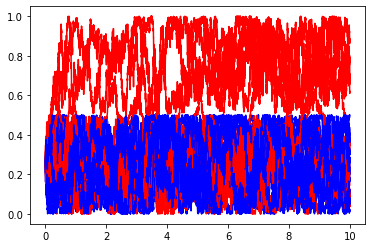

In [15]:
getBothTypeParticles(10, 10000, 10, plot = True)

In [16]:
def getProportion(type, number, baseSteps, Tend, plot = False):
    particles = getParticles(type, number, baseSteps, Tend, plot = False)
    ts = particles[0].ts
    trackLength = len(ts)

    proportionAbove  = np.zeros(trackLength)

    ones = np.ones(trackLength)
    zeros = np.zeros(trackLength)

    for particle in particles:
        track = np.array(particle.zs)

        above = np.where(track > particle.h/2, ones, zeros)

        proportionAbove += above / number

    if plot:
        plt.plot(particles[0].ts, proportionAbove, color = 'red')

    return ts, proportionAbove

In [17]:
def getBothProportions(number, baseSteps, Tend, plot = False, **plotKwargs):
    ts, eulerProportionAbove  = getProportion("Euler", number, baseSteps, Tend, plot = False)
    ts, milsteinProportionAbove =  getProportion("Milstein", number, baseSteps, Tend, plot = False)

    if plot:
        plt.plot(ts, eulerProportionAbove, color = 'red', **plotKwargs)
        plt.plot(ts, milsteinProportionAbove, color = 'blue', **plotKwargs)

    return eulerProportionAbove, milsteinProportionAbove
        

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([0.  , 0.  , 0.  , ..., 0.51, 0.51, 0.51]),
 array([0., 0., 0., ..., 0., 0., 0.]))

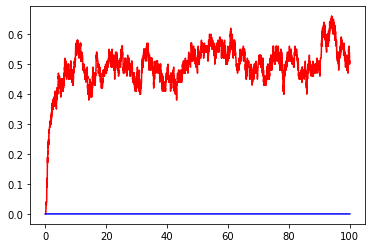

In [18]:
getBothProportions(100, 100000, 100, plot = True)

In [100]:
def blueRedGradient(max, current):
    return (1-(max-current)/max, 0, 1-current/max)

def plotProportionsOverRange(type, range, number, tend):
    for dt in range:
        numsteps = int(tend / dt)
        assert(numsteps < 10e9)
        ts, proportionAbove = getProportion(type, number, numsteps, tend)
        plt.plot(ts, proportionAbove, label = dt, color = blueRedGradient(range[-1], dt))
    plt.legend()

def plotProportionsBothOverRange( range, number, tend):
    plt.figure(figsize = (20,10))
    for dt in range:
        numsteps = int(tend / dt)
        assert(numsteps < 10e9)
        ts, proportionAboveEuler = getProportion("Euler", number, numsteps, tend)
        plt.plot(ts, proportionAboveEuler,  color = blueRedGradient(range[-1], dt), linestyle='dashed')
        ts, proportionAboveMilstein = getProportion("Milstein", number, numsteps, tend)
        plt.plot(ts, proportionAboveMilstein, label = dt, color = blueRedGradient(range[-1], dt))
    plt.legend()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

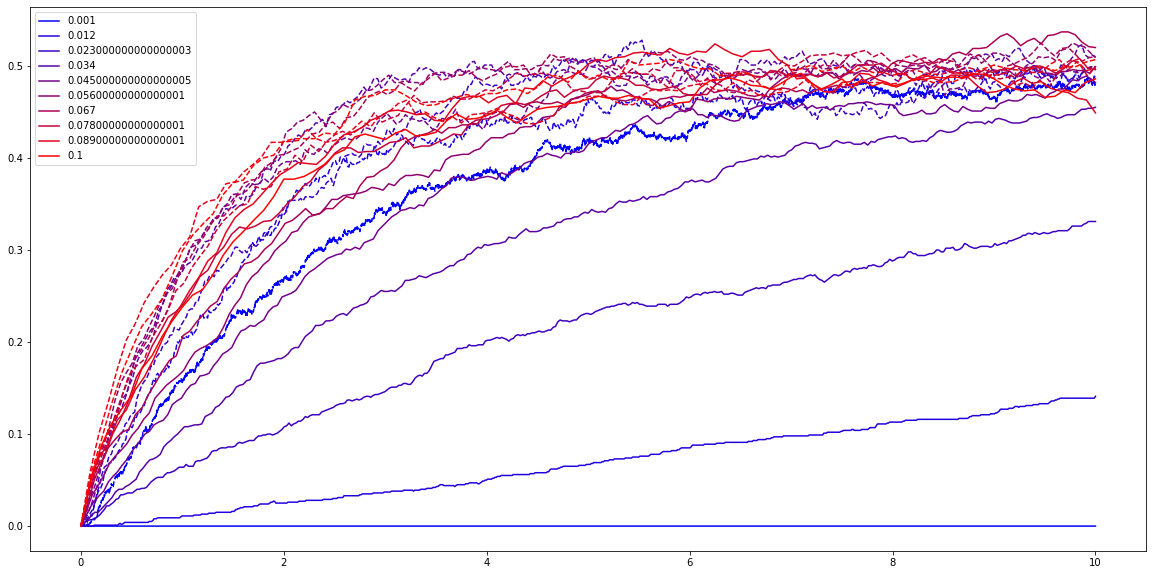

In [103]:
plotProportionsBothOverRange(np.linspace(10e-4, 10e-2, 10), 1000, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

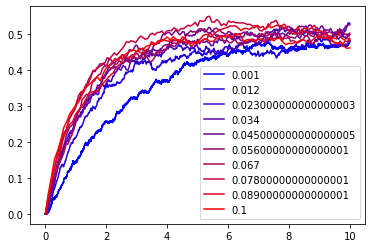

In [105]:
plotProportionsOverRange("Euler", np.linspace(10e-4, 10e-2, 10), 1000, 10)

In [106]:
plotProportionsOverRange("Euler", np.linspace(10e-6, 10e-2, 10), 1000, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

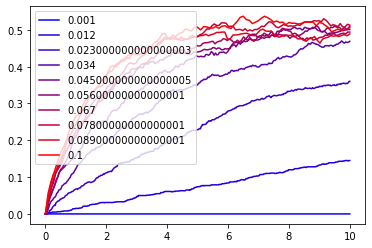

In [21]:
plotProportionsOverRange("Milstein", np.linspace(10e-4, 10e-2, 10), 1000, 10)

In [22]:
def getProportionDt(type, number, tEnd, dt, plot = False):
    steps = int(tEnd/dt)
    getProportion(type, number, steps, tEnd, plot = plot)


  0%|          | 0/1000 [00:00<?, ?it/s]

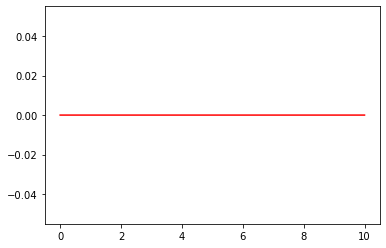

In [23]:
getProportionDt("Milstein", 1000, 10, 0.002, plot = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

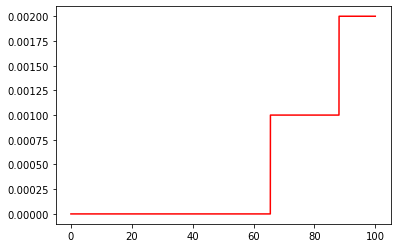

In [24]:
getProportionDt("Milstein", 1000, 100, 0.002, plot = True)

In [25]:
def getParticlesCustom(type, number, baseSteps, Tend, kBar = 1, h = 1, plot = False):
    assert(type == "Euler" or type == "Milstein")
    particles = []

    for i in range(number):
        ts, ws, dws, dt = getWeiner(baseSteps,Tend, 0)

        if type == "Euler":
            eulerParticle = Particle(0.25, kBar = kBar, h = h)
            zs = eulerParticle.simulate(ts, dws, dt)
            particles.append(eulerParticle) 

        if type == "Milstein":
            milsteinParticle = Particle(0.25, kBar = kBar, h = h)
            zs = milsteinParticle.simulateMilstein(ts, dws, dt)
            particles.append(milsteinParticle)

    return particles

In [49]:
def getTracks(krange, hrange, type, number, steps, tEnd, noComb = False):
    shapeFig = plt.figure(figsize = (20,10))
    shapeAx = shapeFig.gca()
    maxRatio = krange[-1]/hrange[0]
    
    if noComb:
        for kBar, h in zip (krange, hrange):
            ratio = kBar/h
            particle = getParticlesCustom(type, number, steps, tEnd, kBar = kBar, h = h, plot = True)[0]
            shapeAx.plot(particle.ts, np.array(particle.zs)/h, label = f"{kBar}/{h} = {ratio}") #color = blueRedGradient(maxRatio, ratio))
            print(particle.zs[-1])
    else:
        for kBar in krange:
            for h in hrange: 
                ratio = kBar/h
                particle = getParticlesCustom(type, number, steps, tEnd, kBar = kBar, h = h, plot = True)[0]
                shapeAx.plot(particle.ts, np.array(particle.zs)/h, label = f"{kBar}/{h} = {ratio}", color = blueRedGradient(maxRatio, ratio))
                print(particle.zs[-1])


    shapeFig.legend()

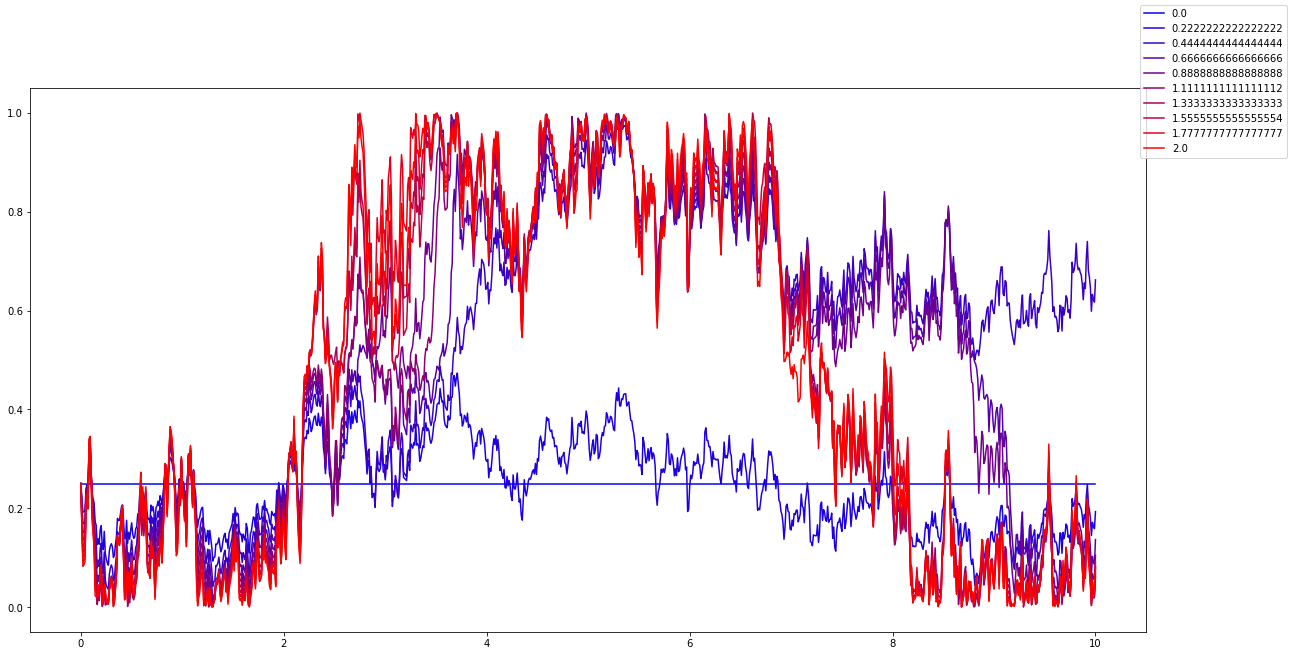

In [28]:
getTracks(np.linspace(0, 2, 10), [1], "Euler", 1, 1000, 10)

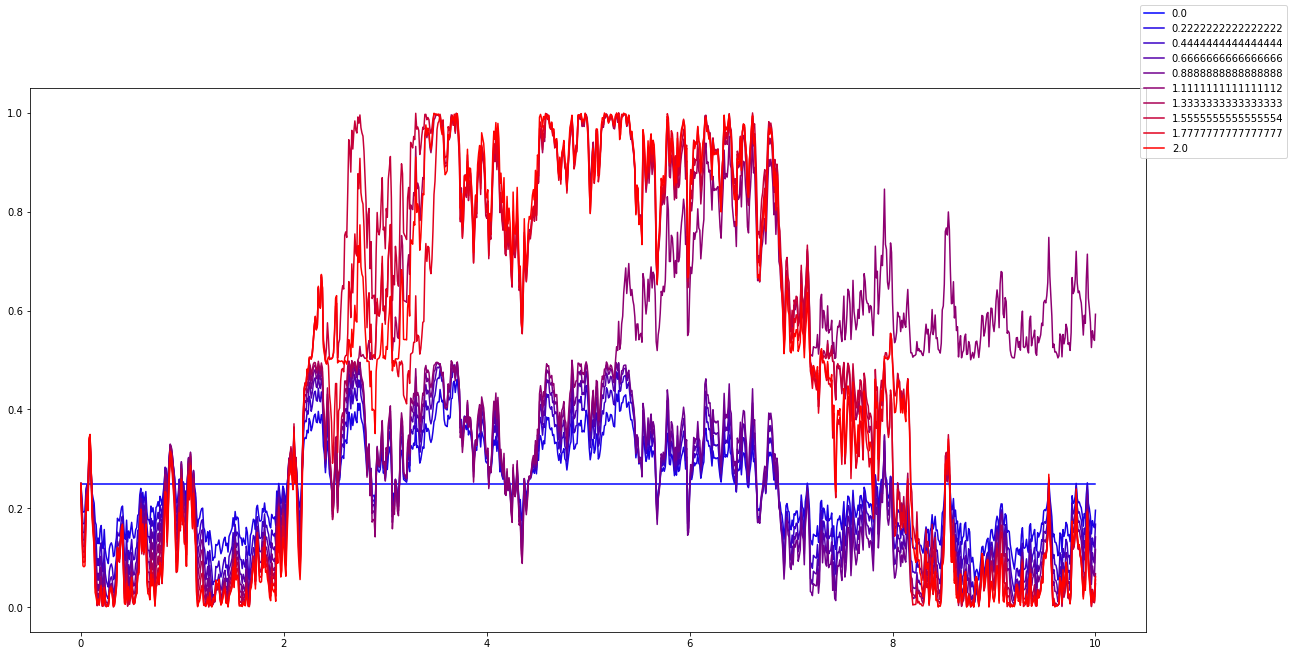

In [29]:
getTracks(np.linspace(0, 2, 10), [1], "Milstein", 1, 1000, 10)

0.010463729137648519
0.10463729137648523
1.0463729137648519
10.463729137648526
104637.29137648524


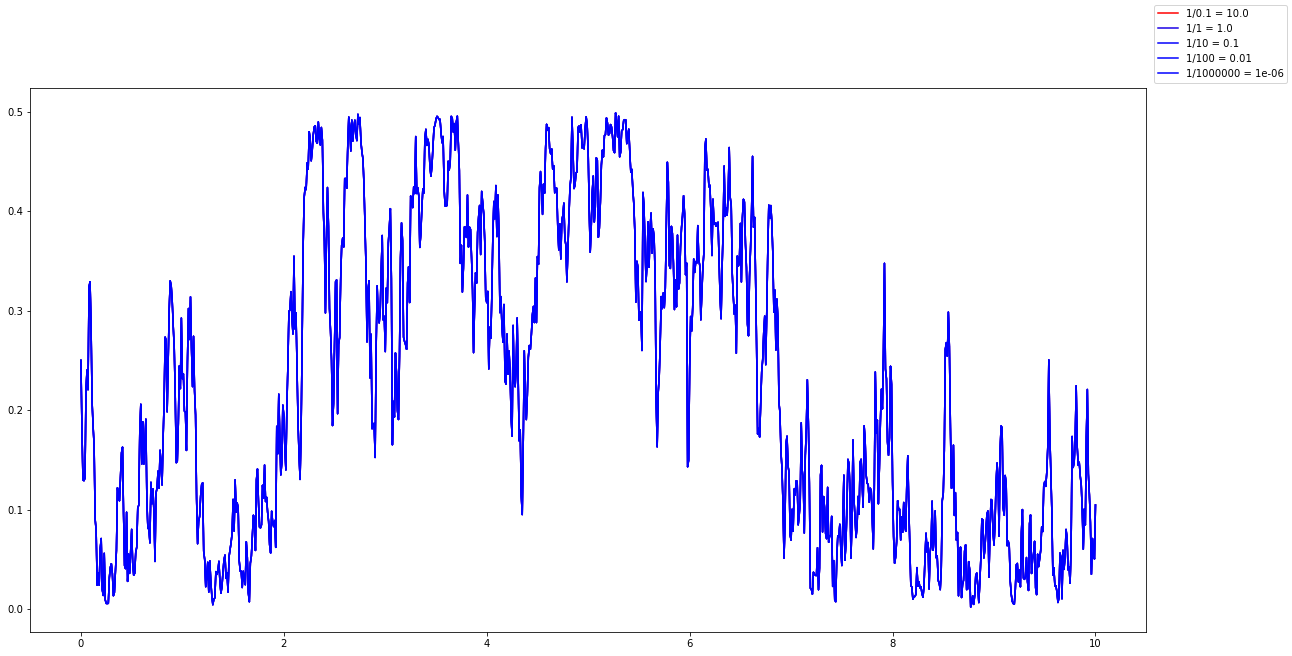

In [89]:
getTracks([1], [0.1, 1, 10, 100, 1000000], "Milstein", 1, 1000, 10)

Kbar: 1 h: 1
0.08731370179997205
Kbar: 10 h: 10
2.1539412813973473


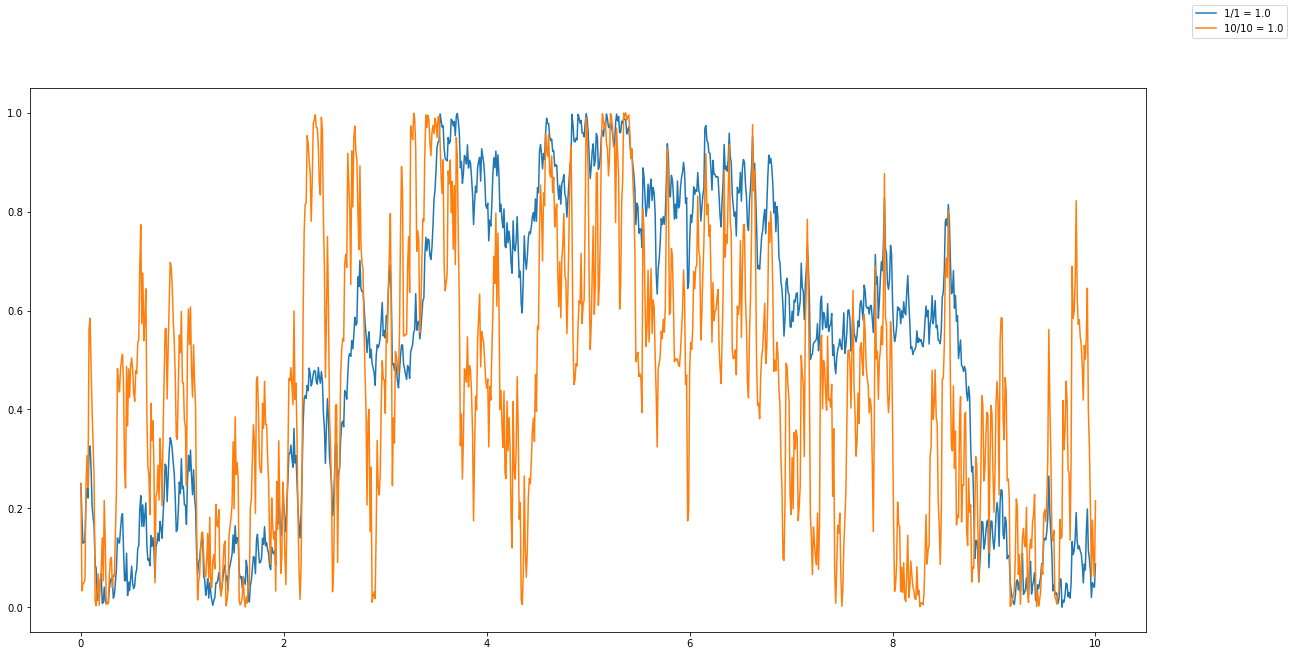

In [73]:
getTracks([1, 10], [1, 10], "Euler", 1, 1000, 10, noComb=True)